In [1]:
%matplotlib widget
from i_o import Paths, RegisteredVolumeReader, VolumeReader
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py, json
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, showvid, get_clipped_array, AVWriter2
from cupyx.scipy.ndimage import maximum_filter, median_filter, convolve1d
from signal_extraction import peristimulus_histogram, stimulus_correlation
from widgets import play_video_widget
from matplotlib.gridspec import GridSpec
from util import plot_traces

from collections import defaultdict
import warpfield
from IPython.display import JSON
import pandas as pd
from widgets import ortho_views_widget
from signal_extraction import peristimulus_histogram

from video import create_projection_image, create_projection_image_heatmap

/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


(217186,)


{0: 'Pulse', 1: '800Hz sine', 2: '1200Hz sine', 3: '2400Hz sine'}

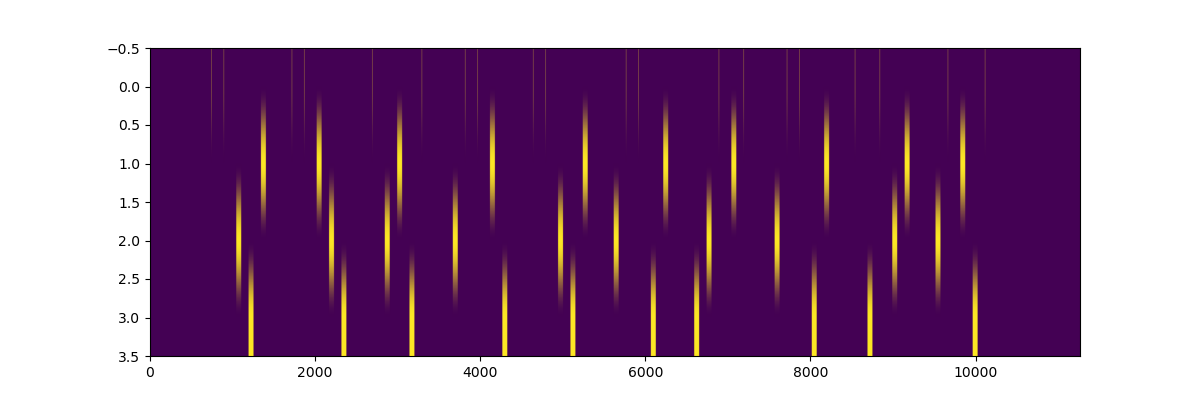

In [3]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
# pn_rec = r"~/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim"
pn_rec = r"~/hpc-r/lfm2025/recordings/"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250828_1718_LB_zf552_para_f1_4"
# dataset_name = "20250902_1940_LB_ZF552_f2_stim2_3"
psf_name = "20250819_1203_PSF_LB_25x_5fps"
bg_name = "20250819_1730_LB_25x_75fps_bg.npy"

import i_o
importlib.reload(i_o)
from i_o import Paths

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,)

traces_data = lazyh5(paths.traces)
# traces_data = lazyh5(paths.pn_outrec+"/traces_3x3x3.h5")
traces = traces_data["traces"]
# segmentation =  lazyh5(paths.segmentation)["segmentation"]
segmentation = traces_data["segmentation"]
print(np.unique(segmentation).shape)
traces_data
import i_o, importlib, pickle
importlib.reload(i_o)
from i_o import get_stimulus, parse_combinations
with open("readable_75fps_stim.pkl", "rb") as f: 
    final_stimulus_id, stim_names = pickle.load(f)
combs = {"pulse": "pulse"}

combinations = parse_combinations(stim_names, combs)
label_to_idx = {v: k for k, v in stim_names.items()}
stim_names_comb = stim_names.copy()
stim_idx = max(stim_names.keys()) + 1

for comb_name, comb_labels in combinations.items():
    stim_names_comb[stim_idx] = comb_name
    stim_idx += 1

# --- Build bool_stimulus ---
n_stim = len(stim_names_comb)
bool_stim = np.zeros((final_stimulus_id.shape[0], n_stim), dtype=bool)


# Individual stimuli (skip silence, which is 0)
for idx in range(1, len(stim_names)):
    bool_stim[:, idx] = final_stimulus_id == idx

if combinations != {}:
    stim_names_comb[0] = "all"
    # First row: True when not silence
    bool_stim[:, 0] = final_stimulus_id != 0
    label_to_indices = defaultdict(list)
    for k, v in stim_names_comb.items():
        label_to_indices[v].append(k)
            
    # Combination stimuli
    for i, (comb_name, comb_labels) in enumerate(combinations.items()):
        comb_idx = len(stim_names) + i
        indices = []
        for lbl in comb_labels:
            indices.extend(label_to_indices[lbl])
        mask = np.isin(final_stimulus_id, indices)
        bool_stim[:, comb_idx] = mask
    stim_names = stim_names_comb

stim_names = { 0: '800Hz sine',
 1: '1200Hz sine',
 2: '2400Hz sine',
 3: 'Pulse'}
bool_stim = bool_stim[:,-4:]

# Desired order
order = [3, 0,1, 2]

# Reorder stim_names
stim_names = {i: stim_names[j] for i, j in enumerate(order)}

# Reorder bool_stim columns
bool_stim = bool_stim[:, order]

fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.imshow(bool_stim[:,:].T, aspect="auto")
stim_names

In [12]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
# pn_rec = r"~/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim"
pn_rec = r"~/hpc-r/lfm2025/recordings/"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

# dataset_name = "20250828_1718_LB_zf552_para_f1_4"
dataset_name = "20250902_1940_LB_ZF552_f2_stim2_3"
psf_name = "20250819_1203_PSF_LB_25x_5fps"
bg_name = "20250819_1730_LB_25x_75fps_bg.npy"

import i_o
importlib.reload(i_o)
from i_o import Paths

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,)

# traces_data = lazyh5(paths.traces)
traces_data = lazyh5(paths.pn_outrec+"/traces_3x3x3.h5")
traces = traces_data["traces"]
segmentation =  lazyh5(paths.segmentation)["segmentation"]
# segmentation = traces_data["segmentation"]
print(np.unique(segmentation).shape)
traces_data
import i_o, importlib, pickle
importlib.reload(i_o)
from i_o import get_stimulus, parse_combinations
with open("readable_75fps_stim_2.pkl", "rb") as f: 
    final_stimulus_id, stim_names = pickle.load(f)
# combs = {"pulse": "pulse"}

# combinations = parse_combinations(stim_names, combs)
# label_to_idx = {v: k for k, v in stim_names.items()}
# stim_names_comb = stim_names.copy()
# stim_idx = max(stim_names.keys()) + 1

# for comb_name, comb_labels in combinations.items():
#     stim_names_comb[stim_idx] = comb_name
#     stim_idx += 1

# # --- Build bool_stimulus ---
# n_stim = len(stim_names_comb)
# bool_stim = np.zeros((final_stimulus_id.shape[0], n_stim), dtype=bool)


# # Individual stimuli (skip silence, which is 0)
# for idx in range(1, len(stim_names)):
#     bool_stim[:, idx] = final_stimulus_id == idx

# if combinations != {}:
#     stim_names_comb[0] = "all"
#     # First row: True when not silence
#     bool_stim[:, 0] = final_stimulus_id != 0
#     label_to_indices = defaultdict(list)
#     for k, v in stim_names_comb.items():
#         label_to_indices[v].append(k)
            
#     # Combination stimuli
#     for i, (comb_name, comb_labels) in enumerate(combinations.items()):
#         comb_idx = len(stim_names) + i
#         indices = []
#         for lbl in comb_labels:
#             indices.extend(label_to_indices[lbl])
#         mask = np.isin(final_stimulus_id, indices)
#         bool_stim[:, comb_idx] = mask
#     stim_names = stim_names_comb

# stim_names = { 0: '1200Hz sine',
#  1: '400Hz sine',
#  2: '800Hz sine',
#  3: 'Pulse'}
# bool_stim = bool_stim[:,-4:]

# # Desired order
# order = [3, 1, 2, 0]

# # Reorder stim_names
# stim_names = {i: stim_names[j] for i, j in enumerate(order)}

# # Reorder bool_stim columns
# bool_stim = bool_stim[:, order]
# # bool_stim = np.roll(bool_stim[::-1], 439, axis = 0)

# fig, ax = plt.subplots(1,1,figsize=(12,4))
# ax.imshow(bool_stim[:,:].T, aspect="auto")
stim_names

(219318,)


{0: 'Silence',
 1: '1pulse_1200Hz',
 2: '1pulse_1200Hz',
 3: 'sin_1200Hz',
 4: 'sin_400Hz',
 5: 'sin_800Hz'}

In [ ]:
import importlib, i_o
importlib.reload(i_o)
from widgets import play_video_widget
from video import AVWriter2, create_projection_image_heatmap
from i_o import VolumeReader, RegisteredVolumeReader
zpos = lazyh5(paths.deconvolved)["zpos"]
ref_vol = lazyh5(paths.registered)["ref_vol"][20:-25,:,:]
mask = cp.asarray(lazyh5(paths.reg_mask)["mask_3d"][:,:,:])
tau = 50

reader = RegisteredVolumeReader(paths, mask = mask,prefetch=3)
dff_video_fn = paths.pn_outrec + f'/final_vid_df_75fps.mp4'
video_fn = paths.pn_outrec + f'/final_vid_75fps.mp4'

dff_video_writer = AVWriter2(dff_video_fn, fps=75, expected_indeces= reader.i_frames, verbose=False, out_fmt="rgb24",bit_rate=15000000 )
video_writer = AVWriter2(video_fn, fps=75, expected_indeces= reader.i_frames, verbose=False, bit_rate=15000000)

average_vol = None
for frame_n, vol in tqdm(reader, desc="dff_vid"):
    vol = cp.asarray(vol)[20:-25,:,:]
    if average_vol is None:
        average_vol = cp.ones_like(vol, dtype=cp.float32) 
    mip = create_projection_image(vol, vmax=13, vmin=0, absolute_limits=True,
                                  zpos=zpos, scalebar=200, text_size = 2,transpose=True,
                                 )
                                  # text=f"{stim_names[final_stimulus_id[int(frame_n)]]} f{frame_n}")
    video_writer.write(mip, frame_n)
    average_vol = (1/tau) * vol+ (1-1/tau) * average_vol
    dff_vol = vol - average_vol
    dff_mip = create_projection_image_heatmap(vol, -dff_vol,
                            vmax=13, vmin=0, absolute_limits=True, text_size = 2,
                            zpos=zpos, scalebar=200, heatmap_vmin = 0.05, heatmap_vmax=0.2, alpha = 0,transpose=True,
                                             )
                            # text=f"{stim_names[final_stimulus_id[int(frame_n)]]} f{frame_n}",)
    dff_video_writer.write(dff_mip, frame_n)
dff_video_writer.close()
video_writer.close()


In [4]:

pad = 30
new_bool = bool_stim
psth = peristimulus_histogram(traces, new_bool, pad = pad)
fluorescence = cp.zeros(shape= psth.shape[:2])
baseline = cp.zeros(shape= psth.shape[:2])
signal_lag_frames = 3
for stim in range(psth.shape[0]):
    stim_length = (np.where(np.diff(new_bool[:,i].astype(int))==-1)[0]-np.where(np.diff(new_bool[:,i].astype(int))==1)[0]).max() + signal_lag_frames
    stim_avg_traces = cp.asarray(psth[stim,:,:,0])
    fluorescence[stim,:] = stim_avg_traces[:,pad:pad+stim_length].mean(axis=1)
    baseline[stim,:] = stim_avg_traces[:,:pad].mean(axis=1)
    
# sorted_indexes = np.argsort(df, axis=1)



Calculating average trace:   0%|          | 0/4 [00:00<?, ?it/s]

for cells:   0%|          | 0/217185 [00:00<?, ?it/s]

for cells:   0%|          | 0/217185 [00:00<?, ?it/s]

for cells:   0%|          | 0/217185 [00:00<?, ?it/s]

for cells:   0%|          | 0/217185 [00:00<?, ?it/s]

In [5]:
dff = ((fluorescence-baseline.mean(0))/baseline.mean(0)).get()
sorted_indexes = np.argsort(dff, axis=1)

In [6]:
import pickle
n_top_traces = 1000
percent = 20
n_traces = int(n_top_traces*(percent/100))

n_stim = bool_stim.shape[1]
plot_pad = 20
# norm_traces = -(traces - np.nanmean(traces, axis = 0))
norm_traces = -(traces - baseline.mean(0).get())/baseline.mean(0).get()

sorted_indexes_ = sorted_indexes#[:,::-1]

baseline_threshold = 0.3

plotting_traces = None

results_for_pickle = []
for i in tqdm(range(n_stim)):
    valid_indexes = baseline[i, sorted_indexes_[i,:]] > baseline_threshold
    idx = np.random.choice(sorted_indexes_[i,valid_indexes.get()][:n_top_traces], n_traces)
    print(norm_traces[:,idx].shape)
    psth = peristimulus_histogram(norm_traces[:,idx], bool_stim, pad = pad)
    print(psth.shape)
    if plotting_traces is None:
        plotting_traces = np.zeros((n_stim, n_traces, (n_stim*psth.shape[2])+(plot_pad*(n_stim-1))))
        plotting_mask = np.zeros(((n_stim*psth.shape[2])+(plot_pad*(n_stim-1))), dtype=bool)
        plotting_mask_id = np.zeros(((n_stim*psth.shape[2])+(plot_pad*(n_stim-1))), dtype=int)-1
        plotting_frames = np.zeros(((n_stim*psth.shape[2])+(plot_pad*(n_stim-1))), dtype=int)*np.nan
    stim_length = (np.where(np.diff(bool_stim[:,i].astype(int))==-1)[0]-np.where(np.diff(bool_stim[:,i].astype(int))==1)[0]).max()
    means = psth[i,:,:,0]
    print(means.shape)
    stds = psth[i,:,:,1]
    pooled_mean = means.mean(axis=0)
    pooled_std = np.sqrt((stds**2 + means**2).mean(axis=0) - pooled_mean**2)
    frames = np.arange(pooled_mean.shape[0])-pad

    for j in range(n_stim):
        # Construct plotting_traces and plotting_mask for all selected cells and all stimuli
        start = j*(psth.shape[2]+plot_pad)
        end = start + psth.shape[2]
        plotting_traces[i, :, start:end] = psth[j,:,:,0]
    start = i*(psth.shape[2]+plot_pad)
    end = start + psth.shape[2]
    plotting_mask[start:end] = True
    plotting_mask_id[start+pad:start+pad+stim_length] = i
    plotting_frames[start:end] = frames

    results_for_pickle.append({
        'idx': idx,
        'means': means,
        'stds': stds,
        'pooled_mean': pooled_mean,
        'pooled_std': pooled_std,
        'frames': frames,
        'stim_length': stim_length,
        'plotting_traces': plotting_traces,
        'plotting_mask': plotting_mask,
        'plotting_mask_stim': plotting_mask_id,
        'plotting_frames': plotting_frames,
    })

# Save results to pickle
with open('stim_evoked_results.pkl', 'wb') as f:
    pickle.dump(results_for_pickle, f)

  0%|          | 0/4 [00:00<?, ?it/s]

(11265, 200)


Calculating average trace:   0%|          | 0/4 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

(4, 200, 120, 2)
(200, 120)
(11265, 200)


Calculating average trace:   0%|          | 0/4 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

(4, 200, 120, 2)
(200, 120)
(11265, 200)


Calculating average trace:   0%|          | 0/4 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

(4, 200, 120, 2)
(200, 120)
(11265, 200)


Calculating average trace:   0%|          | 0/4 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

for cells:   0%|          | 0/200 [00:00<?, ?it/s]

(4, 200, 120, 2)
(200, 120)


/tmp/ipykernel_3975449/2396405229.py:47: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start-0.5-pad, start+stim_length-0.5-pad, color="red", alpha=0.3,edgecolor='none')
/tmp/ipykernel_3975449/2396405229.py:60: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plot_ax.axvspan(start, end, color="red", alpha=0.3,edgecolor='none')
/tmp/ipykernel_3975449/2396405229.py:47: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start-0.5-pad, start+stim_length-0.5-pad, color="red", alpha=0.3,edgecolor='none')
/tmp/ipykernel_3975449/2396405229.py:60: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plot_ax.axvspan(start, end, color="red", alpha=0.3,edgecolor='none')
/tmp/ipykernel_3975449/2396405229.py:47: UserWarning: Setting the 'color' property will override the edgecolor or facecolo

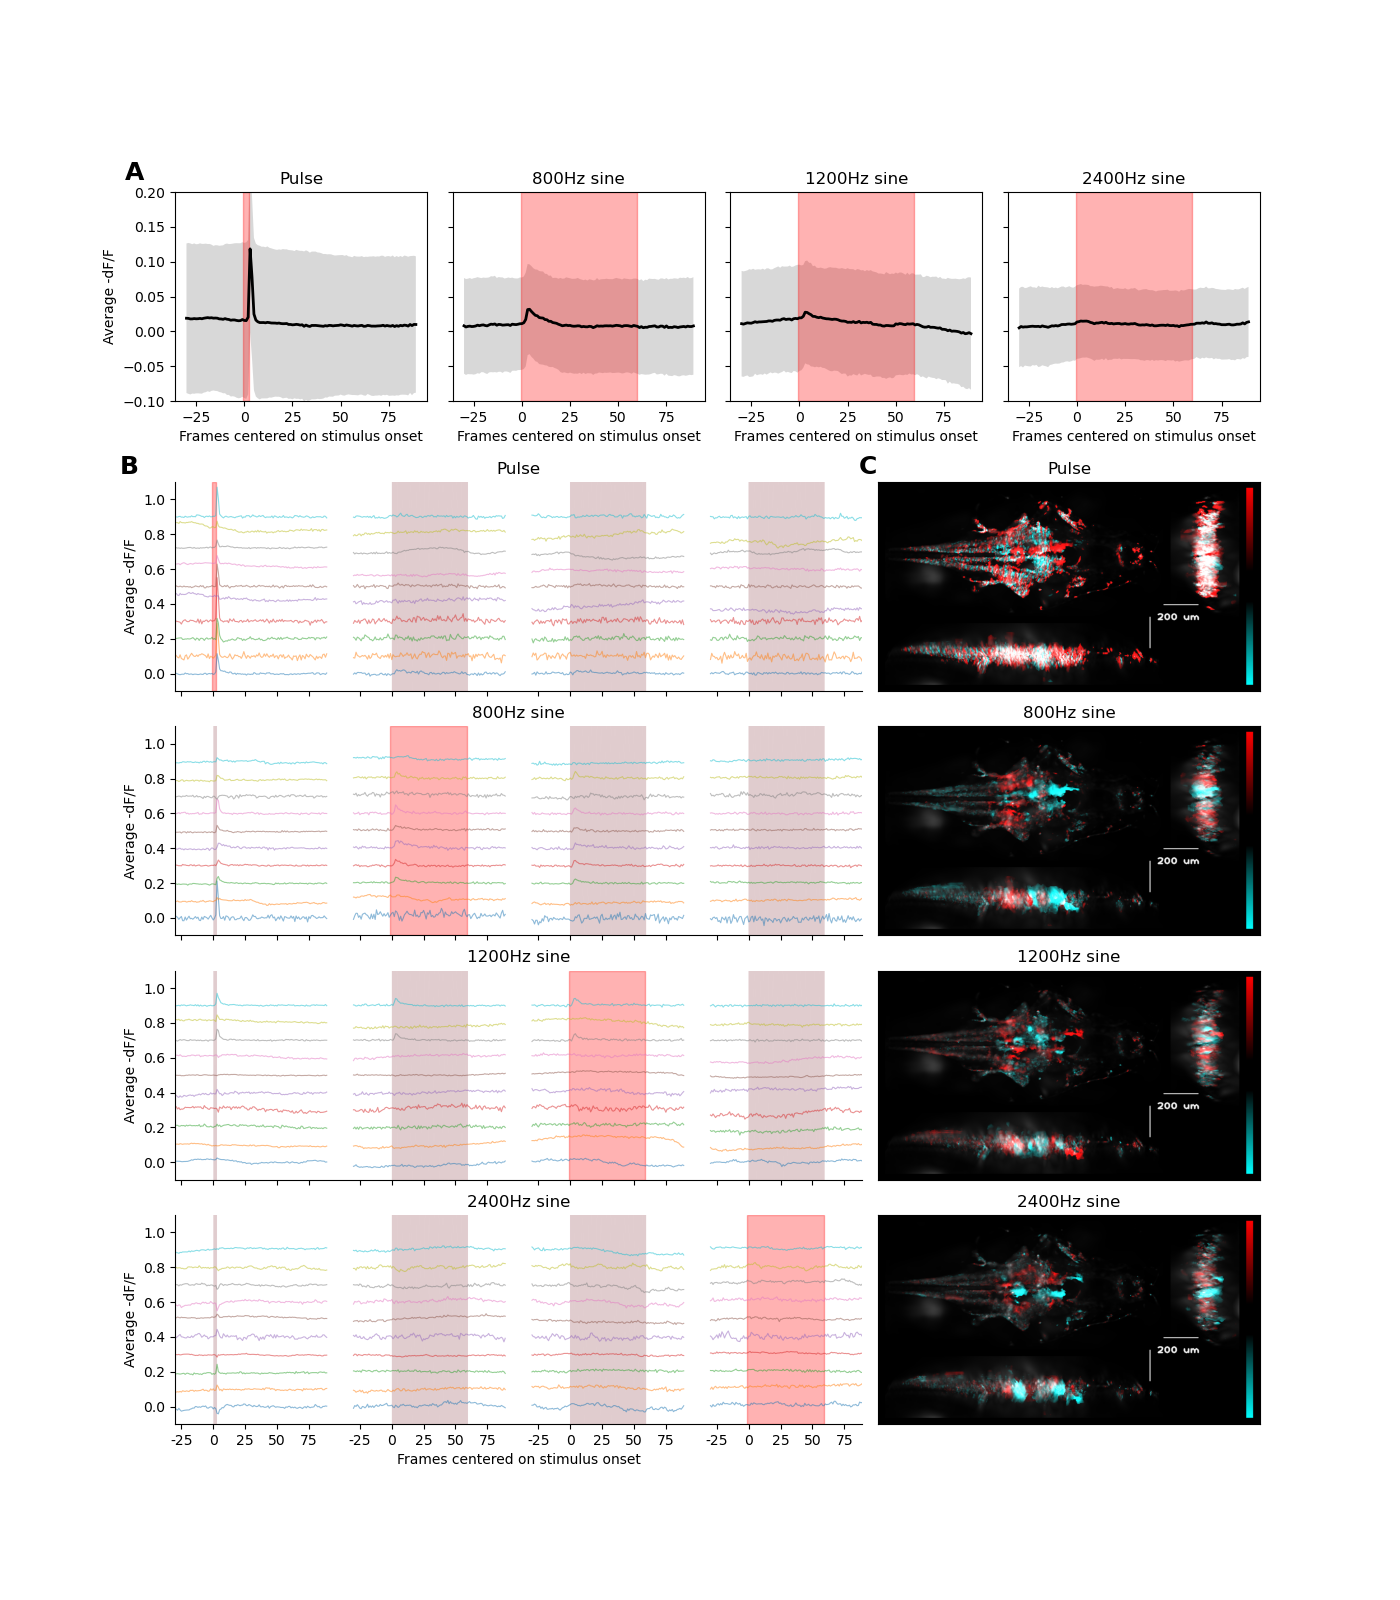

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
import importlib, video
importlib.reload(video)
from video import create_projection_image_heatmap
fig = plt.figure(figsize=(14,16))
outer_gs = gridspec.GridSpec(6, 2, height_ratios=[1,0.05, 1, 1, 1, 1],width_ratios=[1.8, 1], hspace=0.2, wspace=0.03)

# Top row: 4 columns spanning both main columns
top_gs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer_gs[0, :], width_ratios=[1, 1, 1, 1], wspace=0.1)
avg_axes = [fig.add_subplot(top_gs[0, i]) for i in range(4)]
plot_axes = [fig.add_subplot(outer_gs[i+2,0]) for i in range(4)]
spatial_axes = [fig.add_subplot(outer_gs[i+2,1]) for i in range(4)]

plot_n = 10

with open('stim_evoked_results.pkl', 'rb') as f:
    results_for_pickle = pickle.load(f)
tick_values = [-25, 0, 25, 50,75]
plotting_frames = results_for_pickle[0]['plotting_frames']

xticks = []
xticklabels = []

for val in tick_values:
    idxs = np.where(plotting_frames == val)[0]
    if len(idxs) > 0:
        xticks.extend(idxs.tolist())
        xticklabels.extend([str(val)] * len(idxs))
    else:
        # fallback: use closest value in the whole array
        closest_idx = np.argmin(np.abs(plotting_frames - val))
        xticks.append(closest_idx)
        xticklabels.append(str(plotting_frames[closest_idx]))
for i, result in enumerate(results_for_pickle):
    ax = avg_axes[i]
   
    pooled_mean = result['pooled_mean']
    pooled_std = result['pooled_std']
    frames = result['frames']
    # Plot std as shaded region
    ax.fill_between(frames, pooled_mean-pooled_std, pooled_mean+pooled_std, color='gray', alpha=0.3,edgecolor='none')
    ax.plot(frames, pooled_mean, color='black', lw=2)
    start = pad
    stim_length = (np.where(np.diff(bool_stim[:,i].astype(int))==-1)[0]-np.where(np.diff(bool_stim[:,i].astype(int))==1)[0]).max()
    ax.axvspan(start-0.5-pad, start+stim_length-0.5-pad, color="red", alpha=0.3,edgecolor='none')
    ax.set_ylim(-0.1,0.2)
    ax.set_title(stim_names[i])
    ax.set_xlabel("Frames centered on stimulus onset")

    plot_ax = plot_axes[i]
    plotting_traces = result['plotting_traces']
    plotting_mask = result['plotting_mask' ]
    plotting_mask_id = result['plotting_mask_stim']
    plotting_frames =result['plotting_frames']
    scale_factor = 0.1
    plot_traces(plotting_traces[i,:plot_n,:].T, plotting_mask, stim_array = (plotting_mask_id>=0)^(plotting_mask_id == i), n=plot_n, ax = plot_ax,scale_factor = scale_factor, y_add = scale_factor)
    start, end = np.where(np.diff(plotting_mask_id==i))[0]
    plot_ax.axvspan(start, end, color="red", alpha=0.3,edgecolor='none')
    plot_ax.set_title(f"{stim_names[i]}")
    plot_ax.set_ylabel("Average -dF/F")

    plot_ax.spines['right'].set_visible(False)
    plot_ax.spines['top'].set_visible(False)

    plot_ax.set_xticks(xticks)
    plot_ax.set_xticklabels(xticklabels)
    plot_ax.set_xlabel("Frames centered on stimulus onset")

for i in range(1,4):
    avg_axes[i].set_yticklabels([])
avg_axes[0].set_ylabel("Average -dF/F")
for i in range(0,3):
    plot_axes[i].set_xticklabels([])
    plot_axes[i].set_xlabel("")
avg_axes[0].text(-0.2, 1.15, "A", transform=avg_axes[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

plot_axes[0].text(-0.08, 1.13, "B", transform=plot_axes[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
spatial_axes[0].text(-0.05, 1.13, "C", transform=spatial_axes[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

ref_vol = lazyh5(paths.registered)["ref_vol"]
zpos = lazyh5(paths.deconvolved)["zpos"]
for i in range(bool_stim.shape[1]):
    ax = spatial_axes[i]
    spatial_trace = np.zeros(dff.shape[1]+1, dtype = dff.dtype)
    dff_ = -dff[i,:]
    dff_[baseline.mean(0).get()<baseline_threshold] = 0
    spatial_trace[1:]=dff_
    volume = spatial_trace[segmentation]
    ax.imshow(create_projection_image_heatmap(ref_vol, np.clip(volume, -10,10),vmax = 5, heatmap_vmin=0.003,heatmap_vmax=0.02, 
                                              scalebar = 200, zpos = zpos,text_size=2, alpha = 0,
                                              absolute_limits=True, transpose =True),
              cmap="gray", aspect="auto")
    ax.set_title(f"{stim_names[i]}")
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()